<a href="https://colab.research.google.com/github/theplow-kwak/madi/blob/main/%EB%A7%88%EB%94%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
 
nb_path = '/content/notebooks'
 
if 'drive' not in os.listdir():
  drive.mount('/content/drive')
  os.symlink('/content/drive/My Drive/Colab Notebooks/modules', nb_path)
 
if nb_path not in sys.path:
  sys.path.insert(0,nb_path)

ModuleNotFoundError: No module named 'google'

In [5]:
import pandas as pd
import pandas_datareader as pdr
import FinanceDataReader as fdr
 
stock_type = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt'
}
 
class StockCodes:
 
  def __init__(self, mt=None):
    self.get_method = mt
    if self.get_method is None:
      self.stock_codes()
    else:
      self.codes = fdr.StockListing('KRX')[['Market','Name','Symbol']]
      self.codes = self.codes.rename(columns={'Market':'Market','Name': 'name', 'Symbol': 'code'})
 
  def kind_stock_codes(self, market_type='kospi'):
    download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
    download_link = download_link + '?method=download'
    download_link = download_link + '&marketType=' + stock_type[market_type]
    df = pd.read_html(download_link, header=0)[0]
    df['market'] = 'KS' if market_type == 'kospi' else 'KQ'
    return df
 
  def get_code(self, name, target=None):
    code = self.codes.query("name=='{}'".format(name))
    if len(code.index) == 0:
      return '000000'
    if target:
      code = '{:06d}.{}'.format(code.code.item(), code.market.item())
    else:
      if self.get_method is None:
        code = '{:06d}'.format(code.code.item())
      else:
        code = '{}'.format(code.code.item())
    return code
 
  def find(self, name):
    str_expr = "name.str.contains('{}')".format(name)
    print(str_expr)
    code = self.codes.query(str_expr, engine='python')
    return code
 
  def stock_codes(self):
    kospi = self.kind_stock_codes('kospi')
    kosdaq = self.kind_stock_codes('kosdaq')
 
    self.codes = pd.concat([kospi, kosdaq], ignore_index=True)
    self.codes = self.codes[['market','회사명', '종목코드']]
    self.codes = self.codes.rename(columns={'회사명': 'name', '종목코드': 'code'})
 
#    url = 'http://media.kisline.com/highlight/mainHighlight.nice?nav=1&paper_stock={:06d}'.format(code.code.item())
  def getFinancefromNaver(self, name):
      code = self.codes.query("name=='{}'".format(name))
      url = 'http://finance.naver.com/item/main.nhn?code={:06d}'.format(code.code.item())
      print(url)
      tables = pd.read_html(url, encoding='euc-kr')[3]
      tables.set_index(('주요재무정보', '주요재무정보', '주요재무정보'), inplace=True)
      tables.index.rename('주요재무정보', inplace=True)
      tables.columns = tables.columns.droplevel(2)
      tables.columns = tables.columns.droplevel(0)
      return tables
 
 
def readData(name, start=None, end=None):
  data = fdr.DataReader(stock_codes.get_code(name), start, end)
  #data = pdr.get_data_yahoo(get_code(name))
  
  data = data[~(data[['High','Low','Close']] == 0).any(axis=1)]

  timep = 240
  data['high'] = data['High'].rolling(window=timep).max() 
  data['low'] = data['Low'].rolling(window=timep).min() 
  data['enval'] = data['Close'].rolling(window=20).mean() 
  data['mav120'] = data['Close'].rolling(window=120).mean() 
  data['mav240'] = data['Close'].rolling(window=240).mean() 
  data['e_high'] = data['enval'] * 1.2 
  data['e_low'] = data['enval'] * 0.8
  data['madi50'] = data['low'] + (data['high'] - data['low']) * 0.5
  data['madi60'] = data['low'] + (data['high'] - data['low']) * 0.4
  data['madi70'] = data['low'] + (data['high'] - data['low']) * 0.3
  data['madi80'] = data['low'] + (data['high'] - data['low']) * 0.2
  data['madi90'] = data['low'] + (data['high'] - data['low']) * 0.1
  data['v_high'] = data['Volume'].rolling(window=timep).max() 
 
  #if data['high'][-1]
  print(data['high'][-1], data['low'][-1], (data['high'][-1]/ data['low'][-1]) * 100)
  print(data['Close'][-1], data['madi50'][-1])
  return data
 
 
%matplotlib inline 
import pandas as pd
import mplfinance as mpf
 
def drawchart(name, range=200):
 
  tdata = readData(name, '2017')
  data = tdata[-range:]
 
  #fig = mpf.figure(style='yahoo',tight_layout=True, figsize=(12,5))
  #ax1 = fig.add_subplot(2,1,1)
  #ax2 = fig.add_subplot(2,1,2)  
 
  ap0 = [
        mpf.make_addplot(data[['madi60', 'madi70', 'madi80', 'madi90']], color='blue', width=0.5),
        mpf.make_addplot(data[['madi50']],color='g', width=1.5),
        mpf.make_addplot(data[['mav120']],color='teal', width=1),
        mpf.make_addplot(data[['mav240']],color='orange', width=1),
        mpf.make_addplot(data[['high', 'low']],color='c', width=0.5),
        mpf.make_addplot(data[['enval']],color='red', width=1),
        mpf.make_addplot(data[['e_high', 'e_low']],color='black', width=0.5),
        mpf.make_addplot(data[['v_high']],color='black', panel=1, ylabel='Volume', width=0.5),
        ]
 
  mc = mpf.make_marketcolors(
                              up='red',down='blue',
                              inherit=True
                            )
  s  = mpf.make_mpf_style(base_mpf_style="yahoo", edgecolor='black', marketcolors=mc)
  kwargs = dict(type='candle',
            #title=stock_codes.get_code(name),
            ylabel='Price',
            figratio=(4,2),
            panel_ratios=(10,2),
            addplot=ap0)
 
  mpf.plot(data, **kwargs, volume=True, style = s)
 
stock_codes = StockCodes()

In [6]:
stock_codes.codes

,market,name,code
0,KS,DRB동일,4840
1,KS,DSR,155660
2,KS,GS글로벌,1250
3,KS,HDC현대산업개발,294870
4,KS,KEC,92220
...,...,...,...
2319,KQ,한라IMS,92460
2320,KQ,한스바이오메드,42520
2321,KQ,현대사료,16790
2322,KQ,홈센타홀딩스,60560


42550.0 13499.0 315.2085339654789
26500 28024.5


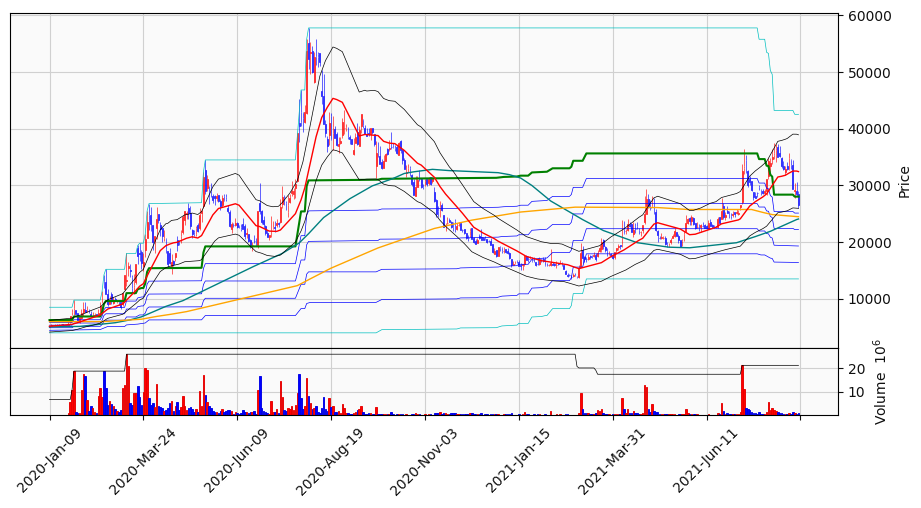

In [7]:
drawchart('랩지노믹스',400)

In [8]:
stock_codes.find('바이오팜')

name.str.contains('바이오팜')


,market,name,code
389,KS,폴루스바이오팜,7630
761,KS,에스케이바이오팜,326030
1134,KQ,전진바이오팜,110020


In [9]:
df_krx = fdr.StockListing('KRX')

In [10]:
df_krx.columns

Index(['Symbol', 'Market', 'Name', 'Sector', 'Industry', 'ListingDate',
       'SettleMonth', 'Representative', 'HomePage', 'Region'],
      dtype='object')

In [11]:
stock_codes.codes

,market,name,code
0,KS,DRB동일,4840
1,KS,DSR,155660
2,KS,GS글로벌,1250
3,KS,HDC현대산업개발,294870
4,KS,KEC,92220
...,...,...,...
2319,KQ,한라IMS,92460
2320,KQ,한스바이오메드,42520
2321,KQ,현대사료,16790
2322,KQ,홈센타홀딩스,60560


In [13]:
str_expr = "Name.str.contains('{}')".format('제')
df_krx.query(str_expr, engine='python')

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
62,097950,KOSPI,CJ제일제당,기타 식품 제조업,"설탕,소맥분,조미식품,육가공식품(돈육,돼지비계,돼지식용설육),대두가공식품,사료,의약...",2007-09-28,12월,"손경식, 최은석 (각자 대표이사)",http://www.cj.co.kr,서울특별시
63,097955,KOSPI,CJ제일제당 우,NaN,NaN,NaT,NaN,NaN,NaN,NaN
65,058820,KOSDAQ,CMG제약,의약품 제조업,의약품,2001-08-31,12월,이주형,http://www.cmgpharma.co.kr,서울특별시
90,069730,KOSPI,DSR제강,1차 철강 제조업,"와이어로프,각종 경강선,철선제품,PC강선,아연도 강연선 제조",2003-01-28,12월,홍하종,http://www.dsrcorp.com,전라남도
154,335870,KOSDAQ,IBKS제12호스팩,금융 지원 서비스업,기타 금융업,2019-12-09,12월,이준규,NaN,서울특별시
...,...,...,...,...,...,...,...,...,...,...
6845,340440,KOSDAQ,한화플러스제1호스팩,금융 지원 서비스업,기업인수,2019-12-27,12월,김양주,NaN,서울특별시
6846,386580,KOSDAQ,한화플러스제2호스팩,금융 지원 서비스업,-,2021-08-05,12월,이동헌,http://hanwha-plus-no2spac.com,서울특별시
6852,101530,KOSPI,해태제과식품,기타 식품 제조업,"홈런볼, 오예스, 맛동산, 부라보콘 등",2016-05-11,12월,신정훈,http://www.ht.co.kr,충청남도
6887,004020,KOSPI,현대제철,1차 철강 제조업,"H형강,제철,제강,철근,압연,스테인레스,주강,시트파일 제조,수출입,중기부품(탱크바퀴...",1987-05-23,12월,안동일,http://www.hyundai-steel.com,인천광역시


In [14]:
df_krx.sort_values('Name')[['Market','Name','Symbol']].head(20)

,Market,Name,Symbol
0,KOSDAQ,3S,060310
1,KOSPI,AJ네트웍스,095570
2,KOSPI,AK홀딩스,006840
3,KOSDAQ,APS홀딩스,054620
4,KOSDAQ,AP시스템,265520
5,KOSDAQ,AP위성,211270
6,KOSPI,ARIRANG 200,152100
7,KOSPI,ARIRANG 200동일가중,295820
8,KOSPI,ARIRANG 200선물레버리지,253150
9,KOSPI,ARIRANG 200선물인버스2X,253160


In [15]:
stock_codes.codes.sort_values('name').head(20)

,market,name,code
816,KQ,3S,60310
299,KS,AJ네트웍스,95570
406,KS,AK홀딩스,6840
1006,KQ,APS홀딩스,54620
2129,KQ,AP시스템,265520
2130,KQ,AP위성,211270
510,KS,BGF,27410
183,KS,BGF리테일,282330
184,KS,BNK금융지주,138930
710,KS,BYC,1460


In [16]:
from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)
 
import pandas as pd
print(pd.__version__)    # 실습할 판다스 버전: 1.0.1
data = {"name": ["White tiger", "Tiger black", "Red tiger"], "age": [5, 7, 9]}
df = pd.DataFrame(data)
display(df)
 
str_expr = 'name.str.contains("tiger", case=False)' 
# 문자열에 tiger 포함
df_q = df.query(str_expr, engine='python')               # 조건 부합 데이터 추출
display_side_by_side(df, df_q)

1.3.2


,name,age
0,White tiger,5
1,Tiger black,7
2,Red tiger,9


,name,age
0,White tiger,5
1,Tiger black,7
2,Red tiger,9
,name,age
0,White tiger,5
1,Tiger black,7
2,Red tiger,9


In [ ]:
import matplotlib as mpl
fontfile = nb_path + '/NanumBrushScript-Regular.ttf'
mpl.font_manager.fontManager.addfont(fontfile)
mpl.rc('font', family='Nanum Brush Script')


In [ ]:
mpl.font_manager._rebuild()

In [ ]:
data = readData('유나이티드제약', '2017')

ValueError: ignored

In [ ]:
data

,Open,High,Low,Close,Volume,Change,high,low,enval,e_high,e_low,madi50,madi60,madi70,madi80,madi90,v_high
Date,,,,,,,,,,,,,,,,,
2017-03-27,18369,19035,16670,17153,1396347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-28,17405,17451,16326,16556,310796,-0.034804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29,16257,16257,15269,15339,276986,-0.073508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-30,15338,15935,14948,15109,174183,-0.014994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-31,15246,15453,14649,14696,93214,-0.027335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-14,45000,46650,44150,44200,407980,-0.012291,57500.0,19350.0,46872.5,56247.0,37498.0,38425.0,34610.0,30795.0,26980.0,23165.0,9772835.0
2020-10-15,44250,44350,41000,41550,493589,-0.059955,57500.0,19350.0,46375.0,55650.0,37100.0,38425.0,34610.0,30795.0,26980.0,23165.0,9772835.0
2020-10-16,41550,42000,39900,40800,303185,-0.018051,57500.0,19350.0,45855.0,55026.0,36684.0,38425.0,34610.0,30795.0,26980.0,23165.0,9772835.0


In [ ]:
%pip install --upgrade --target=$nb_path finance_datareader
%pip install --upgrade --target=$nb_path mplfinance
%pip install --upgrade --target=$nb_path ipympl
#!wget "https://www.wfonts.com/download/data/2016/06/12/nanum-brush-script/NanumBrushScript-Regular.ttf"
#!mv NanumBrushScript-Regular.ttf $nb_path

Requirement already up-to-date: finance_datareader in /usr/local/lib/python3.7/dist-packages (0.9.31)
Requirement already up-to-date: mplfinance in /usr/local/lib/python3.7/dist-packages (0.12.7a7)
Requirement already up-to-date: ipympl in /usr/local/lib/python3.7/dist-packages (0.6.3)


In [ ]:
import urllib.parse
import pandas as pd

MARKET_CODE_DICT = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt',
    'konex': 'konexMkt'
}

DOWNLOAD_URL = 'kind.krx.co.kr/corpgeneral/corpList.do'

def kind_stock_codes(market=None, delisted=False):
    params = {'method': 'download'}

    if market.lower() in MARKET_CODE_DICT:
        params['marketType'] = MARKET_CODE_DICT[market]

    if not delisted:
        params['searchType'] = 13

    params_string = urllib.parse.urlencode(params)
    request_url = urllib.parse.urlunsplit(['http', DOWNLOAD_URL, '', params_string, ''])

    df = pd.read_html(request_url, header=0)[0]
    df.종목코드 = df.종목코드.map('{:06d}'.format)

    return df

In [ ]:
st_codes = kind_stock_codes('krx')

In [ ]:
st_codes.sort_values('회사명')

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
1585,3S,060310,특수 목적용 기계 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1179,AJ네트웍스,095570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,이현우,http://www.ajnet.co.kr,서울특별시
1180,AK홀딩스,006840,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
363,APS홀딩스,054620,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
2172,AP시스템,265520,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
...,...,...,...,...,...,...,...,...,...
567,흥국에프엔비,189980,비알코올음료 및 얼음 제조업,"과일음료(에이드베이스, 스무디, 착즙쥬스 등)",2015-08-07,12월,"박철범, 오길영",http://www.hyungkuk.com,서울특별시
2171,흥국화재,000540,보험업,손해보험,1974-12-05,12월,권중원,http://www.insurance.co.kr,서울특별시
362,흥아해운,003280,해상 운송업,외항화물운송업(케미컬탱커),1976-06-29,12월,이환구,http://www.heung-a.com,서울특별시
880,희림,037440,"건축기술, 엔지니어링 및 관련 기술 서비스업",설계 및 감리용역,2000-02-03,12월,"정영균, 이목운, 허철호, 염두성 (각자대표)",http://www.heerim.com,서울특별시
